In [2]:
import GPy
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
import scipy
from scipy import stats
import seaborn as sns
from math import nan, isnan
import time

import tensorflow as tf
import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()
np.random.seed(123)
random.seed(123)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def flatten(liste):
    return [item for sublist in liste for item in sublist]

def preprocessing(X_s):
    X = []
    for liste in X_s:
        X += liste.copy()
    return np.array(X)

def copie_paths(paths):
    X = []
    for liste in paths:
        X.append(liste.copy())
    return X

def copy_X_D(X_D):
    X = []
    for liste in X_D:
        X.append(liste.copy())
    return np.array(X)

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def concatenate(x, y):
    if len(x)==0:
        return y
    else:
        return np.concatenate((x, y))

def distance(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
        
def sigma_matrix(gp_model, X_v):
    return gp_model.K(X_v, X_v)
    
def sigma_prime_matrix(gp_model, X_v, X_s):
    variance_n = float(gp_model.gp_reg.Gaussian_noise.variance) #1e-5
    a = gp_model.K(X_v, X_v)
    b = gp_model.K(X_v, X_s)
    c = gp_model.K(X_s, X_s)
    d = variance_n*np.eye(len(X_s))
    e = gp_model.K(X_s, X_v)
    f = np.linalg.inv(c + d)
    g = np.dot(b, f)
    h = np.dot(g, e)
    return a - h

def f_D(gp_model, X_v, X_s):
    sigma = sigma_matrix(gp_model, X_v)
    sigma_prime = sigma_prime_matrix(gp_model, X_v, X_s)
    return 0.5 * (np.log(np.linalg.det(sigma)) - np.log(np.linalg.det(sigma_prime)))

def reward_function(gp_model, X_v, X_s_old, X_s_new):
    if len(X_s_old)==0:
        sigma_prime_old = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_old = sigma_prime_matrix(gp_model, X_v, X_s_old)
    if len(X_s_new)==0:
        sigma_prime_new = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_new = sigma_prime_matrix(gp_model, X_v, X_s_new)
    return 0.5 * (np.log(np.linalg.det(sigma_prime_old)) - np.log(np.linalg.det(sigma_prime_new)))

def credit_assignment(env, reward, dones):
    if env.nb_agents==1:
        return np.array([reward])
    rewards = np.zeros(env.nb_agents)
    if reward==0:
        return rewards
    X_s = preprocessing(env.X_s)
    H = np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s)))
    for i in range(env.nb_agents):
        if not dones[i]:
            X_s_i = env.X_s.copy()
            del X_s_i[i]
            X_s_i = preprocessing(X_s_i)
            if len(X_s_i)==0:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_matrix(env.gp_model, env.X_v))) - H)
            else:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s_i))) - H)
    somme = np.sum(rewards)
    if somme==0:
        return rewards
    return rewards*(reward/(np.sum(rewards)))

def construct_graph(graph_dim, graph_unity):
    x = graph_dim[0]
    y = graph_dim[1]
    i, j = 0.0, 0.0
    graph = nx.Graph()
    for k in range(x*y):
        graph.add_node(k, coord=[i, j])
        i += graph_unity
        if i==x*graph_unity:
            i = 0.0
            j += graph_unity
    for k in range(x*y):
        if (k+1)%x!=0:
            graph.add_edge(k, k+1)
        if k<x*y-x:
            graph.add_edge(k, k+x)
    return graph
            
def show_graph(graph):
    nx.draw(graph, with_labels=True, font_weight='bold')

def remove_nodes_from_graph(graph, liste):
    graph.remove_nodes_from(liste)
    return graph

def pollutant_concentration(x, y, z, Q, u, h_s, g, V, T_a, T_s, a_y, b_y, a_z, b_z):
    if x==0:
        x = 0.7
    sigma_y = sigma_function(x, a_y, b_y)
    sigma_z = sigma_function(x, a_z, b_z)
    H = h_s + delta_h(x, u, g, V, T_a, T_s)
    return (Q/(2*np.pi*u*sigma_y*sigma_z))*np.exp(-y**2/(2*sigma_y))*(np.exp(-(z-H)**2/(2*sigma_y))+np.exp(-(z+H)**2/(2*sigma_y)))

def sigma_function(x, a, b):
    return a * (abs(x) ** b)

def delta_h(x, u, g, V, T_a, T_s):
    F = (g/np.pi) * V * ((T_s - T_a)/T_s)
    return (1.6 * (F**(1/3)) * (x**(2/3))) / u

def incertitude_initiale(sigma, graph):
    return 0.5 * np.log(np.linalg.det(sigma)) + (graph.number_of_nodes()/2) * (1 + np.log(2*np.pi))

def coord_to_id(coord, graph_dim):
    return graph_dim[0] * int(coord[1]) + int(coord[0])
    
def plot_results(steps, avg_rewards, err, train_py_env, grd_truth_variances, grd_truth_lengthscales, perturbations_steps):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].plot(steps, avg_rewards)
    axs[1].plot(steps, err)
    axs[2].plot(range(1,len(train_py_env.liste_variances)+1), train_py_env.liste_variances)
    axs[3].plot(range(1,len(train_py_env.liste_lengthscales)+1), train_py_env.liste_lengthscales)
    for var in grd_truth_variances:
        axs[2].axhline(y=10, color='red', linestyle='--')
    for l in grd_truth_lengthscales:
        axs[3].axhline(y=l, color='red', linestyle='--')
    for s in perturbations_steps:
        axs[1].axvline(x=s, color='green', linestyle='--')
        axs[2].axvline(x=s/100, color='green', linestyle='--')
        axs[3].axvline(x=s/100, color='green', linestyle='--')
    
def compute_means(graph_dim, height, Q, u, h_s, g, V, T_a, T_s, a_y, b_y, a_z, b_z, display=False):
    means = []
    i = 0
    j = -1 * int(graph_dim[1]/2)
    i_m = 0
    j_m = 0
    matrice = [[-1 for _ in range(graph_dim[0])] for _ in range(graph_dim[1])]
    for _ in range(graph_dim[1]):
        for _ in range(graph_dim[0]):
            concentration = pollutant_concentration(i, j, height, Q, u, h_s, g, V, T_a, T_s, a_y, b_y, a_z, b_z)
            means.append(concentration + 10)
            matrice[i_m][j_m] = concentration
            i += 1
            j_m += 1
        j += 1
        i = 0
        j_m = 0
        i_m += 1
    if display:
        ax = sns.heatmap(matrice, linewidth = 0, cmap = 'coolwarm')
        ax.invert_yaxis()
    return means

def compute_covariance_matrix(X_v, variances, lengthscale):
    cov = [[0 for _ in range(len(X_v))] for _ in range(len(X_v))]
    cst = -2*(lengthscale**2)
    for i in range(len(X_v)):
        for j in range(len(X_v)):
            cov[i][j] = np.sqrt(variances[i]) * np.sqrt(variances[j]) * np.exp(distance(X_v[i], X_v[j])**2/cst)
    return cov

def linear_regression(X, Y):
    y = []
    for ele in Y:
        y.append(np.sqrt(ele))
    a, b, _, _, _ = stats.linregress(X, y)
    return a, b

In [3]:
def collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, memory_window, gamma):
    X_D = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    cov = compute_covariance_matrix(X_D, variances_lengthscale[0], variances_lengthscale[1])
    X, Y = [], []
    for _ in range(exploration_steps):
        Y_D = np.random.multivariate_normal(np.array(means), cov, 1)[0]
        Y_D = np.reshape(Y_D, (len(Y_D),1))
        Y_D[Y_D<0] = 0.1
        sparse_nodes = random.sample(range(0, graph.number_of_nodes()), nb_agents)
        
        for i in sparse_nodes:
            l = variances[i]
            l[0], l[1], l[2] = weighted_variance(l[0], l[1], l[2], Y_D[i][0], memory_window, gamma)
        
        sorted_nodes = sorted(sparse_nodes)
        
        for j in range(len(sorted_nodes)):
            if j==0 or sorted_nodes[j]!=sorted_nodes[j-1]:
                for i in range(len(sorted_nodes)):
                    if sorted_nodes[i]!=sorted_nodes[j] and (sorted_nodes[i]!=sorted_nodes[i-1] or i==0):
                        if distance(X_D[sorted_nodes[j]], X_D[sorted_nodes[i]])<=3.1:
                            l = liste_covariances[sorted_nodes[j]][sorted_nodes[i]]
                            l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_D[sorted_nodes[j]], Y_D[sorted_nodes[i]], memory_window, gamma)
        """
        if sorted_nodes[0]==0:
            for i in range(1,len(sorted_nodes)):
                if sorted_nodes[i]!=sorted_nodes[i-1]:
                    l = covariances[sorted_nodes[i]]
                    l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_D[0], Y_D[sorted_nodes[i]], memory_window, gamma)
        """
        X.append(X_D[sparse_nodes])
        Y.append(Y_D[sparse_nodes])
    return incertitude_initiale(cov, graph), np.array(X), np.array(Y)

def hyperparameters_estimator(gp_model, graph, graph_dim, memory_window, gamma):
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    moyenne = np.reshape(gp_model.gp_reg.predict(X_v)[0], (graph.number_of_nodes(),))
    ###########################################
    coeff = linear_regression(moyenne, np.array(variances)[:,0])
    ###########################################
    lengthscale, cpt = 0, 0
    for j in range(len(liste_covariances)):
        covariances = liste_covariances[j]
    #j = 0
        for i in range(len(covariances)):
            if covariances[i][0]>1:
                covariance = covariances[i][1] - covariances[i][2] * covariances[i][3]
                if 0<covariance<np.sqrt(variances[j][0])*np.sqrt(variances[i][0]):
                    cpt += covariances[i][0]
                    lengthscale += find_lengthscale(X_v[j], X_v[i], covariance, np.sqrt(variances[j][0])*np.sqrt(variances[i][0])) * covariances[i][0]
    if cpt!=0:
        lengthscale /= cpt
    else:
        lengthscale = 0
    return moyenne, np.array(variances)[:,0], lengthscale, coeff

def find_lengthscale(x1, x2, y, var):
    return distance(x1, x2) * np.sqrt(-0.5/np.log(y/var))

def weighted_covariance(n, moy_prod, moy_x, moy_y, x_new, y_new, memory_capacity, gamma):
    gamma = 0.9
    if n>memory_capacity:
        return n + 1, gamma * moy_prod + (1-gamma) * x_new * y_new, gamma * moy_x + (1-gamma) * x_new, gamma * moy_y + (1-gamma) * y_new
    return n + 1, (n * moy_prod + x_new * y_new)/(n + 1), (n * moy_x + x_new)/(n + 1), (n * moy_y + y_new)/(n + 1)

def weighted_variance(var, moy, n, x_new, memory_capacity, gamma):
    if n>memory_capacity:
        a = gamma*(var+(moy**2)) + (1-gamma)*(x_new**2)
        moy = gamma * moy + (1-gamma) * x_new
    else:
        a = (n*(var+(moy**2)) + (x_new**2))/(n+1)
        moy = (n*moy+x_new)/(n+1)
    return a-moy**2, moy, n+1

In [4]:
class GP_Model():
    def __init__(self, x, y, variances, lengthscale, graph_dim):
        self.X = x
        self.Y = y
        self.variances = variances
        self.lengthscale = lengthscale
        self.graph_dim = graph_dim
        self.gp_reg = GPy.models.GPRegression(self.X, self.Y, GPy.kern.RBF(2))
        self.gp_reg.optimize(messages=False)
        
    def K(self, X_1, X_2):
        res = np.array([[0. for _ in range(len(X_2))] for _ in range(len(X_1))])
        ids_2 = [coord_to_id(X_2[k], self.graph_dim) for k in range(len(X_2))]
        cst = -2*(self.lengthscale**2)
        for i in range(len(X_1)):
            id_1 = coord_to_id(X_1[i], self.graph_dim)
            for j in range(len(X_2)):
                res[i][j] = np.sqrt(self.variances[id_1]) * np.sqrt(self.variances[ids_2[j]]) * np.exp(distances[id_1][ids_2[j]]**2/cst)
        return res
    
    def set_XY(self, x, y):
        self.X = x
        self.Y = y
        self.gp_reg.set_XY(self.X, self.Y)
        #self.gp_reg.optimize(messages=False)

True Variances:  [379.0809  83.7225  32.6041  15.9201   5.1529  83.7225  68.7241  55.2049
  23.5225   7.29    32.6041  55.2049  43.1649  32.6041   9.7969  15.9201
  23.5225  32.6041  23.5225  15.9201   5.1529   7.29     9.7969  15.9201
   9.7969]
Variances:  [347.93886573 127.86299832  40.04108035   3.03849795   8.65558154
  32.72736757  16.00036659  20.16364381  18.63785194   9.26118173
  28.2331647  111.21122996  55.32530628  32.6226712    5.85121895
  29.01546791  24.29931765  30.22200868  28.97247926   3.99986574
   4.81540376   7.60845392   4.07768217  19.61860999  13.90107516]
Lengthscale:  [1.4158923]
Carte:  [50.81018437 32.59702117 19.0396353  12.83605944  8.72706095 31.87736114
 24.94560517 20.78723811 17.99444185 12.21612739 18.48696619 19.71686206
 21.42903997 20.48106039 14.14835476 13.41490405 16.82690408 19.61917225
 19.41754234 14.59674904 10.83056163 12.45894908 14.05164494 14.78401045
 13.08363098]
(a, b) =  (0.3615490196195394, -1.5800324557732948)
Incertitude initia

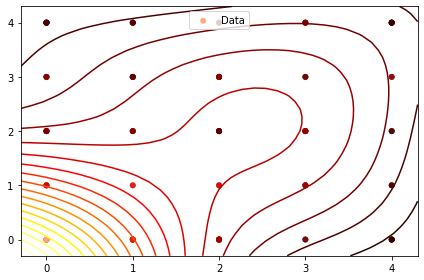

In [5]:
graph_dim = (5, 5)
graph_unity = 1
graph = construct_graph(graph_dim, graph_unity)
X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
means = np.array([60, 30, 20, 15, 10, 30, 27.5, 25, 17.5, 11.25, 20, 25, 22.5, 20, 12.5, 15, 17.5, 20, 17.5, 15, 10, 11.25, 12.5, 15, 12.5])
variances_lengthscale = [(0.344 * means - 1.17)**2, 2]
nb_agents = 4
exploration_steps = 50
memory_window = 1000
gamma = 0.99

variances = [[0, 0, 0] for _ in range(graph.number_of_nodes())]
liste_covariances = [[[0, 0, 0, 0] for _ in range(graph.number_of_nodes())] for _ in range(graph.number_of_nodes())]
distances = [[distance(X_v[i], X_v[j]) for j in range(len(X_v))] for i in range(len(X_v))]

incertitude, x, y = collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, memory_window, gamma)

x = np.reshape(x, (nb_agents*exploration_steps,2))
y = np.reshape(y, (nb_agents*exploration_steps,1))
gp_model = GP_Model(x, y, 0, 0, graph_dim)

moyenne, var, l, coeff = hyperparameters_estimator(gp_model, graph, graph_dim, memory_window, gamma)
print("True Variances: ", variances_lengthscale[0])
print("Variances: ", var)
print("Lengthscale: ", l)
print("Carte: ", moyenne)
print("(a, b) = ", coeff)

gp_model.variances = var
gp_model.lengthscale = l
#display(gp_model.gp_reg)
gp_model.gp_reg.plot()
#print(gp_model.predict(np.array([[0, 0]])))
#print(gp_model.predict(np.array([[4, 4]])))
print("Incertitude initiale : ", incertitude_initiale(sigma_matrix(gp_model, X_v), graph))

In [6]:
def update_gp_model(gp_model, x, y, var, l):
    X = np.concatenate((gp_model.X, x))[-2000:]
    Y = np.concatenate((gp_model.Y, y))[-2000:]
    gp_model.variances = var
    gp_model.lengthscale = l
    gp_model.set_XY(X, Y)
    return gp_model

def take_measurements(nodes, means, X_v, graph_dim, memory_window, gamma):
    cov = compute_covariance_matrix(X_v, variances_lengthscale[0], variances_lengthscale[1])
    Y_v = np.random.multivariate_normal(np.array(means), cov, 1)[0]
    Y_v = np.reshape(Y_v, (len(Y_v),1))
    Y_v[Y_v<0] = 0.1
    
    for i in nodes:
        l = variances[i]
        l[0], l[1], l[2] = weighted_variance(l[0], l[1], l[2], Y_v[i][0], memory_window, gamma)
    
    sorted_nodes = sorted(nodes)
    
    for j in range(len(sorted_nodes)):
            if j==0 or sorted_nodes[j]!=sorted_nodes[j-1]:
                for i in range(len(sorted_nodes)):
                    if sorted_nodes[i]!=sorted_nodes[j] and (sorted_nodes[i]!=sorted_nodes[i-1] or i==0):
                        if distance(X_v[sorted_nodes[j]], X_v[sorted_nodes[i]])<=3.1:
                            l = liste_covariances[sorted_nodes[j]][sorted_nodes[i]]
                            l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_v[sorted_nodes[j]], Y_v[sorted_nodes[i]], memory_window, gamma)
    """
    if sorted_nodes[0]==0:
        for i in range(1,len(sorted_nodes)):
            if sorted_nodes[i]!=sorted_nodes[i-1]:
                l = covariances[sorted_nodes[i]]
                l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_v[0], Y_v[sorted_nodes[i]], memory_window, gamma)
    """
    return X_v[nodes], Y_v[nodes]

def clean():
    for ele in liste_covariances:
        for sub_ele in ele:
            sub_ele[0], sub_ele[1], sub_ele[2], sub_ele[3] = 0, 0, 0, 0

In [7]:
class pfeEnv(py_environment.PyEnvironment):

    def __init__(self, graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, variance_0, lengthscale_0, coeff_0, memory_window, gamma, train_env=True):
        self.nb_agents = nb_agents
        self.graph = graph
        self.graph_unity = graph_unity
        self.graph_dim = graph_dim
        self.initial_budgets = budgets/self.graph_unity
        self.budgets = self.initial_budgets.copy()
        if initial_positions!=None:
            self.initial_positions = copie_paths(initial_positions)
            self.paths = copie_paths(initial_positions)
        else:
            self.initial_positions = None
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        self.X_v = np.array([self.graph.nodes[i]["coord"] for i in range(self.graph.number_of_nodes())])
        self.gp_model = gp_model
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=3, name="action")
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.nb_agents*2,), dtype=np.float32, minimum=np.zeros((self.nb_agents*2,)), name="observation")
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self._episode_ended = False
        #################################
        self.cpt_update_gp_model = 0
        self.memory_window, self.gamma = memory_window, gamma
        self.x, self.y = np.array([]), np.array([])
        self.liste_variances, self.liste_lengthscales, self.coeffs = [variance_0], [lengthscale_0], [coeff_0]
        self.train_env = train_env
        self.indice_lengthscale = 0
        
    def current_node(self, id_agent):
        return self.paths[id_agent][-1]

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def formater(self):
        for i in range(len(self.neighbors)):
            liste = self.neighbors[i]
            node = self.current_node(i)
            try:
                if liste[0]>=node-1:
                    liste.insert(0,-1)
                if liste[1]!=node-1:
                    liste.insert(1,-1)
                if liste[2]!=node+1:
                    liste.insert(2,-1)
            except:
                pass
            for _ in range(4-len(liste)):
                liste.append(-1)

    def _reset(self):
        if self.initial_positions!=None:
            self.paths = copie_paths(self.initial_positions)
        else:
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)] 
        self.formater()
        self.budgets = self.initial_budgets.copy()
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))
        
    def _step(self, abstract_actions):
        if self._episode_ended:
            return self.reset()
        actions = []
        for i in range(self.nb_agents):
            actions.append(self.neighbors[i][abstract_actions[i]])
        X_s_old = preprocessing(self.X_s)
        for i in range(self.nb_agents):
            if not self.dones[i]:
                if actions[i]!=-1:
                    self.X_s[i].append([graph.nodes[actions[i]]["coord"][0], graph.nodes[actions[i]]["coord"][1]])
                    self.budgets[i] -= 1
                else:
                    actions[i] = self.current_node(i)
                    self.budgets[i] -= 0.3
                if self.budgets[i]<1:
                    self.dones[i] = True
                    self.cpt_done += 1
                self.paths[i].append(actions[i])
                coord = self.graph.nodes[self.current_node(i)]["coord"]
                self._state[2*i] = coord[0]
                self._state[2*i+1] = coord[1]
        
        
        positions, mesures = take_measurements(actions, means, self.X_v, self.graph_dim, self.memory_window, self.gamma)
        if self.train_env:
            m, var, l, coeff = hyperparameters_estimator(self.gp_model, self.graph, self.graph_dim, self.memory_window, self.gamma)
            self.liste_variances.append(var)
            self.liste_lengthscales.append(l)
            self.moy = m
            self.coeffs.append(coeff)
            ##########################
            vi, vs = min(self.liste_lengthscales[self.indice_lengthscale:]), max(self.liste_lengthscales[self.indice_lengthscale:])
            if vs-vi>3:
                clean()
                self.indice_lengthscale = len(self.liste_lengthscales)
            ##########################
            self.x = concatenate(self.x, positions)
            self.y = concatenate(self.y, mesures)
            self.cpt_update_gp_model = (self.cpt_update_gp_model + 1)%100
            if self.cpt_update_gp_model==0:
                self.gp_model = update_gp_model(self.gp_model, self.x, self.y, var, l)
                self.x, self.y = np.array([]), np.array([])
        
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        reward = reward_function(self.gp_model, self.X_v, X_s_old, preprocessing(self.X_s))
        if self.cpt_done==self.nb_agents:
            self._episode_ended = True
            return ts.termination(np.array(self._state, dtype=np.float32), reward)
        return ts.transition(np.array(self._state, dtype=np.float32), reward=reward, discount=0.97)

In [8]:
num_iterations = 15000
fc_layer_params = (128,64,)
replay_buffer_capacity = 5000
batch_size = 128
learning_rate = 1e-5

num_atoms = 51
min_q_value = -20
max_q_value = 20
n_step_update = 3

num_eval_episodes = 10
log_eval_interval = 1000

max_episode_length = 25
budgets = 25 * np.ones(nb_agents)

In [9]:
initial_positions = None #[[random.randint(0, graph.number_of_nodes()-1)] for i in range(nb_agents)]
train_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, coeff, memory_window, gamma, train_env=True), duration=max_episode_length)
eval_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, coeff, memory_window, gamma, train_env=False), duration=max_episode_length)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

agents_tf = []
eval_policies = []
collect_policies = []
policies_checkpointers = []

for i in range(nb_agents):
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        fc_layer_params=fc_layer_params)
        
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)

    agents_tf.append(categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        min_q_value=min_q_value,
        max_q_value=max_q_value,
        n_step_update=n_step_update,
        target_update_period=5,
        target_update_tau=0.05,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=0.99,
        train_step_counter=train_step_counter))

    agents_tf[-1].initialize()

    eval_policies.append(agents_tf[-1].policy)
    collect_policies.append(agents_tf[-1].collect_policy)
    collect_policies[-1]._epsilon = 1.
    
    policies_checkpointers.append(common.Checkpointer(ckpt_dir='Collisions_Politique__'+str(i), policy=eval_policies[-1]))

In [10]:
def compute_avg_return(environment, policies, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            actions = []
            for i in range(nb_agents):
                actions.append(policies[i].action(time_step).action.numpy()[0])
            actions = tf.convert_to_tensor([actions])
            time_step = environment.step(actions)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def random_compute_avg_return(environment, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            actions = [random.randint(0, 3) for _ in range(nb_agents)]
            actions = tf.convert_to_tensor([actions])
            time_step = environment.step(actions)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, environment_py, policies):
    time_step = environment.current_time_step()
    actions = []
    actions_step = []
    dones = environment_py.dones.copy()
    for i in range(nb_agents):
        actions_step.append(policies[i].action(time_step))
        actions.append(actions_step[-1].action.numpy()[0])
    actions = tf.convert_to_tensor([actions])
    next_time_step = environment.step(actions)
    rewards = credit_assignment(environment_py, next_time_step.reward.numpy()[0], dones)
    for i in range(nb_agents):
        if not dones[i]:
            nts = next_time_step._replace(reward=tf.convert_to_tensor([rewards[i]], dtype=np.float32))
            traj = trajectory.from_transition(time_step, actions_step[i], nts)
            replay_buffers[i].add_batch(traj)
            
def random_collect_step(environment, environment_py):
    time_step = environment.current_time_step()
    actions = [random.randint(0, 3) for _ in range(nb_agents)]
    actions = tf.convert_to_tensor([actions])
    next_time_step = environment.step(actions)

In [12]:
replay_buffers = []
for i in range(nb_agents):
    replay_buffers.append(tf_agents.replay_buffers.TFUniformReplayBuffer(
        data_spec = agents_tf[i].collect_data_spec,
        batch_size = train_env.batch_size,
        max_length = replay_buffer_capacity))

iterators = []
for i in range(nb_agents):
    dataset = replay_buffers[i].as_dataset(
        num_parallel_calls=3,
        sample_batch_size=batch_size,
        num_steps=2).prefetch(3)
    iterators.append(iter(dataset))

In [13]:
print(compute_avg_return(eval_env, collect_policies, num_eval_episodes))
print(compute_avg_return(eval_env, eval_policies, num_eval_episodes))

steps = []
avg = []
err = []

for i in range(nb_agents):
    agents_tf[i].train = common.function(agents_tf[i].train)
    agents_tf[i].train_step_counter.assign(0)

for _ in tqdm(range(500)):
    collect_step(train_env, train_py_env, collect_policies)

for step in tqdm(range(1, num_iterations+1)):
    if step%25==0:
        for cp in collect_policies:
            cp._epsilon = max(cp._epsilon*0.99, 0.1)
    
    #if step==3000:
        #variances_lengthscale[1] += 1
    if step==2000:
        means = means + 20
    
    for _ in range(1):
        collect_step(train_env, train_py_env, collect_policies)
    
    for i in range(nb_agents):
        experience, _ = next(iterators[i])
        agents_tf[i].train(experience=experience)
        
    if step%log_eval_interval==0:
        avg_return = compute_avg_return(eval_env, eval_policies, num_eval_episodes)
        steps.append(step)
        avg.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        print("Variances : ", train_py_env.liste_variances[-1])
        mae = np.mean(np.abs(train_py_env.liste_variances[-1]-variances_lengthscale[0]))
        print("MAE des variances : ", mae)
        print("(a, b) = ", train_py_env.coeffs[-1])
        print("Lengthscale : ", train_py_env.liste_lengthscales[-1])
        err.append(np.mean((train_py_env.moy-means)**2))
        print("MSE de la moyenne : ", err[-1])
        if mae>4:
            clean()
            for ele in variances:
                ele[0], ele[1], ele[2] = 0, 0, 0
            for _ in range(50):
                collect_pilot_data(nb_agents, 50, graph, graph_dim, means, memory_window, gamma)

6.1818743
2.0901055


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  7%|████▉                                                                     | 1000/15000 [05:08<18:03:07,  4.64s/it]

step = 1000: Average Return = 2.394273281097412
Variances :  [400.13209152  79.97602493  33.08379406  12.30488007   5.5894541
  82.26847178  62.06987946  52.87726766  22.82510174   6.55075362
  41.76349736  50.65750093  40.29836657  33.53655018   9.43011846
  17.32394518  24.57813961  31.98404745  28.11076141  16.97167606
   5.70235367   8.65544766   8.81623349  15.39436747  10.66329465]
MAE des variances :  2.8832516744950083
(a, b) =  (0.3481505161220898, -1.233898153457365)
Lengthscale :  [2.04053503]
MSE de la moyenne :  0.9705174740283751


 13%|█████████▊                                                                | 2000/15000 [09:50<14:30:39,  4.02s/it]

step = 2000: Average Return = 2.4510459899902344
Variances :  [399.54969819  86.46514932  32.71783759  13.53057329   5.30929775
  84.7171881   67.81709114  51.24865034  22.7995482    7.19094814
  39.89591079  53.88686241  41.35709152  36.2683752   10.45020241
  17.2056001   25.52143125  32.20419647  26.87242396  16.6913851
   5.75242754   8.35173073   9.02958142  15.18275761   9.63973961]
MAE des variances :  2.336596714771301
(a, b) =  (0.35079578650995297, -1.2581004952162527)
Lengthscale :  [2.03765648]
MSE de la moyenne :  399.11249090841306


 20%|███████████████▍                                                             | 2999/15000 [13:35<55:18,  3.62it/s]

step = 3000: Average Return = 8.343979835510254
Variances :  [412.61111111 157.45216603  94.66630194  56.7783556   93.73245188
 143.38907026 107.74857782  95.4133173   77.10134209 102.20734789
  84.09471896 107.65258534  87.30248611 100.87777158 105.51854047
  65.35784018  81.03215633  96.33307007 102.52568195 118.15835136
  86.65087123  80.77872707 101.57353002 116.33975386  10.00241556]
MAE des variances :  63.90132167910236
(a, b) =  (0.21316800393350466, 1.4756298149937024)
Lengthscale :  [0.96935852]
MSE de la moyenne :  2.1585965223168926


 27%|███████████████████▋                                                      | 4001/15000 [18:17<11:40:24,  3.82s/it]

step = 4000: Average Return = 3.6595444679260254
Variances :  [366.67199192  78.90235983  28.94405071  14.47019377   5.29509558
  80.2007612   58.60177701  58.16899794  22.57637114   7.18477174
  32.2378242   53.74771023  43.18590006  27.16297547  10.16454412
  16.23769027  24.00268591  34.4108573   23.62941764  14.60387782
   5.33953285   6.93836786  10.16264344  15.39397261   8.52746762]
MAE des variances :  2.1808476791076763
(a, b) =  (0.33108759473635424, -7.617621266818892)
Lengthscale :  [1.18593018]
MSE de la moyenne :  1.4376436372156576


 33%|████████████████████████▋                                                 | 5000/15000 [23:07<17:36:38,  6.34s/it]

step = 5000: Average Return = 4.620763301849365
Variances :  [384.49829564  80.53543621  29.64787377  14.79873709   5.03516298
  79.54949188  59.2996184   55.89335626  22.08572961   6.73357163
  31.81305017  57.3408641   43.15230937  28.44084215  10.13142377
  16.6908442   24.94095624  34.3662399   23.12443906  15.12978716
   5.42141243   7.02120012   9.99489029  14.9772055    9.35465042]
MAE des variances :  1.7510590933265453
(a, b) =  (0.3513049623407983, -8.384768747593874)
Lengthscale :  [1.80118101]
MSE de la moyenne :  1.612723410346672


 40%|█████████████████████████████▉                                             | 5999/15000 [27:53<1:10:16,  2.13it/s]

step = 6000: Average Return = 5.525445461273193
Variances :  [327.06165054  82.51214793  29.17615826  15.41044208   4.92825677
  68.34557522  59.29664157  53.39431035  22.45620057   7.02733185
  32.6883941   56.73221654  42.56313396  28.96062806   9.52687095
  17.33993731  24.4641947   34.93448229  22.80194474  17.04751271
   5.46315971   7.1014736    9.86050907  17.63362544   8.95683746]
MAE des variances :  4.044741118951213
(a, b) =  (0.3222710231214256, -7.312175146792813)
Lengthscale :  [1.90176381]
MSE de la moyenne :  1.08663524501398


 47%|██████████████████████████████████▌                                       | 7000/15000 [34:02<15:36:11,  7.02s/it]

step = 7000: Average Return = 4.4749860763549805
Variances :  [391.56526649  82.20281423  34.11754117  16.27807332   4.51138507
  84.60732043  67.45574707  52.66746864  21.6103557    7.13799553
  30.99723646  52.59399415  42.82153139  35.16879025   9.9092664
  15.76865353  23.7514181   33.55490498  25.87910397  15.71367639
   5.47909833   7.92283846  10.78460064  15.84781489  10.08204403]
MAE des variances :  1.4683317403324179
(a, b) =  (0.3380489922268415, -7.8122973149396255)
Lengthscale :  [2.49943557]
MSE de la moyenne :  1.2391040238563822


 53%|███████████████████████████████████████▍                                  | 8000/15000 [39:20<13:56:53,  7.17s/it]

step = 8000: Average Return = 5.2755327224731445
Variances :  [342.72959204  81.89006899  35.02886995  15.95377427   4.59543595
  95.91360063  64.77441354  53.04626964  23.48068624   7.39266899
  30.24768514  53.8013204   44.47263129  34.72052917   9.54215518
  15.20733055  24.11277525  34.1149082   26.22080475  15.29085868
   5.34079606   7.95385628  10.45854274  16.1254042   10.05129421]
MAE des variances :  3.007877585569787
(a, b) =  (0.32797929950406374, -7.392098153022313)
Lengthscale :  [1.93190336]
MSE de la moyenne :  1.6932084473017586


 60%|█████████████████████████████████████████████                              | 9001/15000 [44:06<7:54:50,  4.75s/it]

step = 9000: Average Return = 4.598736763000488
Variances :  [341.12118564  78.07452556  33.39215229  16.24807959   4.44776729
  75.91461598  59.45028263  53.70672522  24.50438204   7.39262586
  30.49420203  53.00140616  44.38735699  34.34076482   9.50076526
  15.32969845  24.11677643  34.12447435  25.95886893  15.35227755
   5.47018284   7.76350405  10.39575929  16.02211725  10.24389727]
MAE des variances :  3.2123916095924825
(a, b) =  (0.3139984451135025, -6.979929849168465)
Lengthscale :  [2.12119226]
MSE de la moyenne :  1.2739648839954523


 67%|████████████████████████████████████████████████▋                        | 10000/15000 [49:09<11:10:58,  8.05s/it]

step = 10000: Average Return = 6.717146396636963
Variances :  [422.27880628  98.88024591  39.20563695  16.36520572   4.74436488
  80.04450084  68.58516412  52.86971507  24.30872775   7.44969206
  32.43890322  48.35826277  45.08616311  34.09530643   9.36060634
  17.1926232   23.73993757  33.76624306  25.5785594   15.21699943
   5.45501894   7.5456215   10.3314781   15.14222174  10.11662367]
MAE des variances :  3.6548260501456706
(a, b) =  (0.3638516802190659, -8.68089640836227)
Lengthscale :  [1.69499968]
MSE de la moyenne :  1.5587061938556945


 73%|███████████████████████████████████████████████████████▋                    | 10999/15000 [54:05<12:10,  5.48it/s]

step = 11000: Average Return = 5.979046821594238
Variances :  [323.07477531  76.77664355  42.59401891  16.76304494   4.92945462
  66.57710795  67.62833615  53.41417234  24.0961659    7.60083925
  27.98573532  52.39118222  44.60069255  33.5266888    9.50371635
  18.56228504  23.97793978  34.09323281  24.85713859  14.83510848
   5.54028589   7.63162651  10.3341804   15.33397682   9.6423922 ]
MAE des variances :  4.560865522638392
(a, b) =  (0.31077126267223376, -6.782679751736124)
Lengthscale :  [1.86836584]
MSE de la moyenne :  1.0755367674942686


 76%|█████████████████████████████████████████████████████████▌                  | 11354/15000 [56:25<18:07,  3.35it/s]


ValueError: Received a time_step input that converted to a nan array. Did you accidentally set some input value to None?.
Got:
nan

In [14]:
print(steps)
print("##################")
print(avg)
print("##################")
print(err)
print("##################")
print(train_py_env.coeffs)
print("##################")
print(train_py_env.liste_lengthscales)

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000]
##################
[2.3942733, 2.451046, 8.34398, 3.6595445, 4.6207633, 5.5254455, 4.474986, 5.2755327, 4.598737, 6.7171464, 5.979047]
##################
[0.9705174740283751, 399.11249090841306, 2.1585965223168926, 1.4376436372156576, 1.612723410346672, 1.08663524501398, 1.2391040238563822, 1.6932084473017586, 1.2739648839954523, 1.5587061938556945, 1.0755367674942686]
##################
[(0.3615490196195394, -1.5800324557732948), (0.3980198622386136, -1.9667850054917517), (0.3980237352607037, -1.971020246541629), (0.39960709589507637, -1.9841490118882303), (0.39922229527977254, -1.9832711535009926), (0.3986192799819739, -1.9789263042584508), (0.39942869141272924, -1.9571627774610088), (0.3993912829703592, -1.9599800587195748), (0.39943364748662163, -1.9585267249710903), (0.4002699578709402, -1.9646345333579962), (0.4020425787765701, -1.9765988879261496), (0.4009727154484353, -1.9627077913848954), (0.4078282173257509,

[array([1.4158923]), array([1.86049408]), array([1.86984673]), array([1.87419961]), array([1.87973704]), array([1.88091938]), array([2.07945871]), array([2.11078919]), array([2.37071286]), array([2.37897292]), array([2.34073868]), array([2.34538205]), array([2.07182069]), array([2.07533108]), array([1.94777702]), array([1.92557282]), array([1.89652097]), array([1.90799]), array([1.92455174]), array([1.93065077]), array([2.00955728]), array([1.93646993]), array([2.20881684]), array([2.08160131]), array([1.96866102]), array([2.08103427]), array([2.0803926]), array([2.07591241]), array([2.01256791]), array([2.007364]), array([2.01335098]), array([2.04597024]), array([2.03662452]), array([2.04911068]), array([2.04238286]), array([2.04149664]), array([2.04796839]), array([2.04147865]), array([2.03830068]), array([2.03696693]), array([2.00605265]), array([2.01868742]), array([2.03462321]), array([2.04834625]), array([2.05161807]), array([2.01700182]), array([1.9951394]), array([1.99577162]),

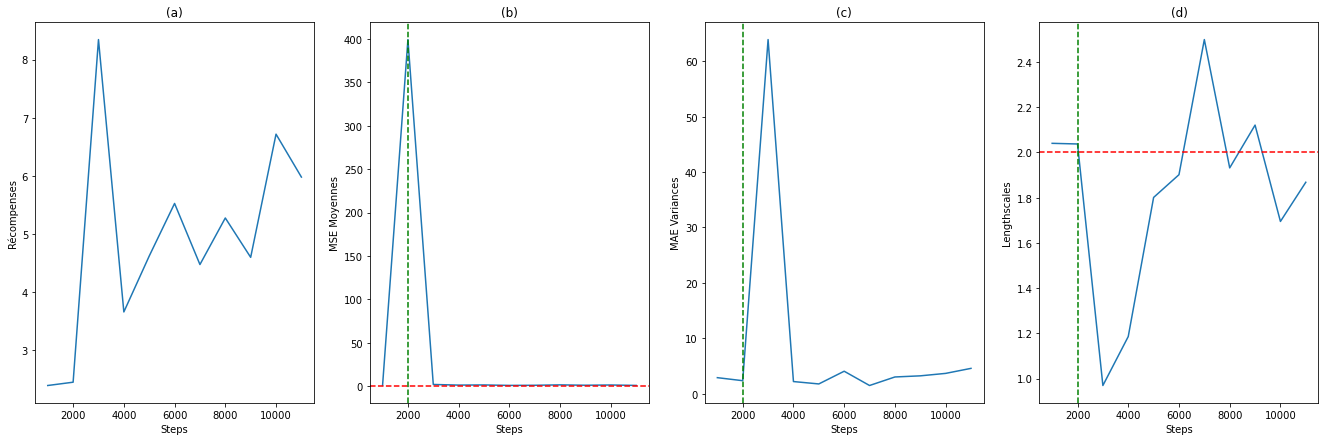

In [3]:
steps = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000]
avg = [2.3942733, 2.451046, 8.34398, 3.6595445, 4.6207633, 5.5254455, 4.474986, 5.2755327, 4.598737, 6.7171464, 5.979047]
err = [0.9705174740283751, 399.11249090841306, 2.1585965223168926, 1.4376436372156576, 1.612723410346672, 1.08663524501398, 1.2391040238563822, 1.6932084473017586, 1.2739648839954523, 1.5587061938556945, 1.0755367674942686]
err_variances = [2.8832516744950083, 2.336596714771301, 63.90132167910236, 2.1808476791076763, 1.7510590933265453, 4.044741118951213, 1.4683317403324179, 3.007877585569787, 3.2123916095924825, 3.6548260501456706, 4.560865522638392]
ccs = [2.04053503, 2.03765648, 0.96935852, 1.18593018, 1.80118101, 1.90176381, 2.49943557, 1.93190336, 2.12119226, 1.69499968, 1.86836584]

fig, axs = plt.subplots(1, 4, figsize=(23, 7))
axs[0].plot(steps, avg)
axs[1].plot(steps, err)
axs[2].plot(steps, err_variances)
axs[3].plot(steps, ccs)

axs[1].axhline(y=0, color='red', linestyle='--')
axs[3].axhline(y=2, color='red', linestyle='--')

axs[1].axvline(x=2000, color='green', linestyle='--')
axs[2].axvline(x=2000, color='green', linestyle='--')
axs[3].axvline(x=2000, color='green', linestyle='--')

axs[0].set_title('(a)')
axs[1].set_title('(b)')
axs[2].set_title('(c)')
axs[3].set_title('(d)')
axs[0].set(xlabel='Steps', ylabel="Récompenses")
axs[1].set(xlabel='Steps', ylabel="MSE Moyennes")
axs[2].set(xlabel='Steps', ylabel="MAE Variances")
axs[3].set(xlabel='Steps', ylabel="Lengthscales")
plt.show()

In [21]:
total_return = 0.0
episodes = 1
for _ in range(episodes):
    time_step = eval_env.reset()
    episode_return = 0.0
    while not time_step.is_last():
        actions = []
        for i in range(nb_agents):
            actions.append(eval_policies[i].action(time_step).action.numpy()[0])
        actions = tf.convert_to_tensor([actions])
        time_step = eval_env.step(actions)
        #print(credit_assignment(eval_py_env, time_step.reward.numpy()[0], eval_py_env.dones.copy()))
        episode_return += time_step.reward
    print(eval_py_env.paths)
    print(episode_return.numpy()[0])
    print("##################################")
    total_return += episode_return
avg_return = total_return / episodes
print("Moyenne : ", avg_return.numpy()[0])

Reward :  24.165461855925976
[6.26527879 6.09462284 5.85173557 5.95382529]
Reward :  14.277524864343498
[4.96624374 2.31758648 2.51421336 4.47948137]
Reward :  9.867613349062694
[3.86720685 1.27572923 1.25581047 3.46886725]
Reward :  5.08209500699661
[1.98520626 0.68308456 0.70150589 1.71229843]
Reward :  5.189434961150596
[2.01542317 0.70986803 1.28393984 1.18020396]
Reward :  0.6924427035080072
[0.29923962 0.10440146 0.18771232 0.10108932]
Reward :  0.9483399204529945
[0.46854284 0.16145663 0.16195974 0.15638072]
Reward :  5.101016852671648
[3.15823238 0.83547236 0.23355574 0.87375652]
Reward :  9.402737582096549
[5.66920686 1.23453679 0.36223297 2.136761  ]
Reward :  6.370057310943636
[3.80989798 0.64885767 0.60627443 1.30502703]
Reward :  0.43838664482744605
[0.26280096 0.04428664 0.04223552 0.08906354]
Reward :  5.015820090663851
[2.98302667 0.50517091 0.5049101  1.02271234]
Reward :  6.590999267236114
[3.73721281 0.59025597 0.57286785 1.69066251]
Reward :  0.5540921216355343
[0.3

In [14]:
for i in range(nb_agents):
    policies_checkpointers[i].save(global_step=agents_tf[i].train_step_counter)